In [2]:
import pandas as pd #for data importing and manipulation
import numpy as np #for data manipulation and cleaning
import seaborn as sns #data visualization
import matplotlib.pyplot as plt #data visualization
%matplotlib inline

In [4]:
train=pd.read_csv('Data/train_data.csv')
test=pd.read_csv('Data/test_data.csv')
sub=pd.read_csv('Data/sample_submission.csv')

In [10]:
from catboost import CatboostClassifier

In [11]:
#imputting missing values for both train and test
train.fillna(0,inplace=True)
test.fillna(0,inplace=True)

In [12]:
train.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [13]:
test_id = test["Customer Id"]
print(test_id)

0       H11920
1       H11921
2        H9805
3        H7493
4        H7494
         ...  
3064    H11583
3065    H11720
3066    H11721
3067    H12408
3068     H9021
Name: Customer Id, Length: 3069, dtype: object


In [40]:
train = train.drop('Customer Id',axis=1)
test = test.drop('Customer Id',axis=1)

In [14]:
X = train.drop('Claim',axis=1)
y = train.Claim
print(y)

0       0
1       0
2       0
3       0
4       0
       ..
7155    0
7156    1
7157    0
7158    0
7159    0
Name: Claim, Length: 7160, dtype: int64


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# Split the data into 30% validation and 70% training
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state=101)

In [17]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [45]:
#a=np.arange(10)
#a

In [46]:
#np.where([[True,False],[True,True]],
        #[[1,2],[3,4]],
        #[[9,8],[7,6]])

In [47]:
#x,y = np.ogrid[:3,:4]
#np.where(x<y,x,10+y)

In [19]:
model=CatBoostClassifier(iterations=800, #leaf_estimation_iterations=10,#800
                              learning_rate=0.1,
                              depth=4,#loss_function='MultiClass',#,scale_pos_weight=200,
                             #l2_leaf_reg=5,
                             bootstrap_type='Bernoulli',
                              subsample=0.9,
                              eval_metric='AUC',
                              metric_period=20,
                                   #class_weight s=0,
                              #od_type='Iter',
                              #od_wait=45,
                              #random_seed=10,
                              allow_writing_files=False)

In [22]:
model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_val, y_val))

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.Customer Id, Building_Painted, Building_Fenced, Garden, Settlement, NumberOfWindows, Geo_Code

In [51]:
y_pred=model.predict_proba(test)[:,1]

In [52]:
from sklearn.metrics import roc_auc_score

In [53]:
print(roc_auc_score(y_val,model.predict_proba(X_val)[:,1]))

0.7277547327736885


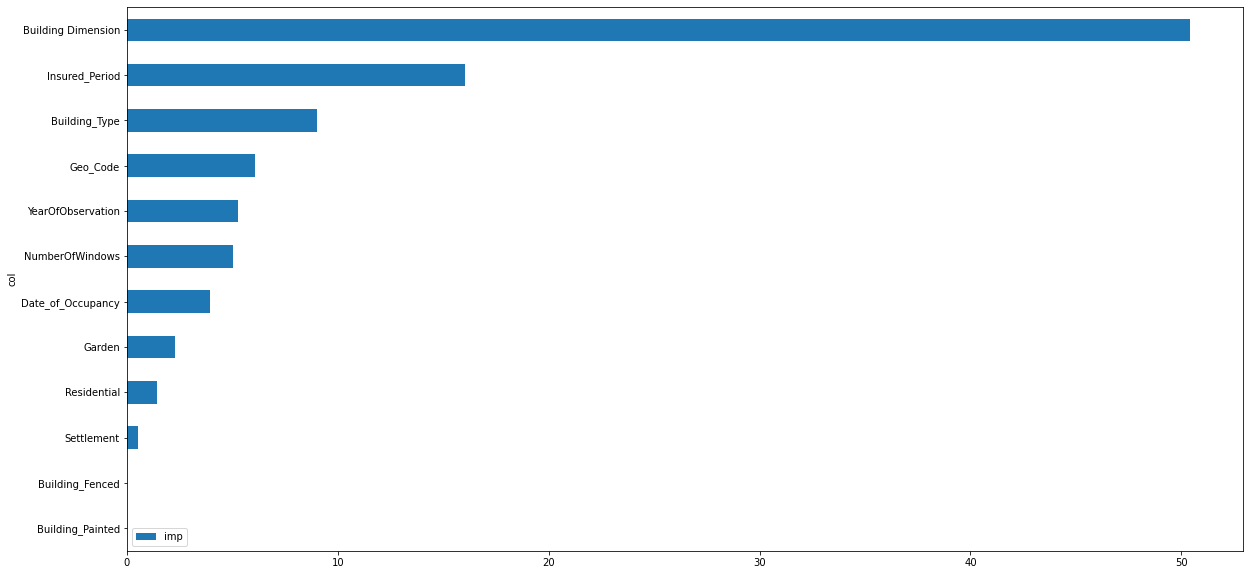

In [56]:
fea_imp = pd.DataFrame({'imp':model.feature_importances_,'col':X.columns})
fea_imp = fea_imp.sort_values(['imp','col'],ascending=[True,False]).iloc[-30:]
_ = fea_imp.plot(kind='barh',x='col',y='imp',figsize=(20,10))
plt.savefig('catboost_feature_importance.png')

In [58]:
d={"Customer Id":test_id,'Claim': y_pred}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["Customer Id","Claim"]]

In [59]:
test_predictions.head()

,Customer Id,Claim
0,H11920,0.104581
1,H11921,0.082996
2,H9805,0.070471
3,H7493,0.154213
4,H7494,0.146762


In [60]:
test_predictions.to_csv('i2.csv',index=False)